In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("youtube_videos.csv")
df.head()

,keyword,video_id,title,channel,published,views,likes,comments
0,data science,RBSUwFGa6Fk,What is Data Science?,IBM Technology,2022-06-13T12:00:14Z,793311,16888,305
1,data science,FsSrzmRawUg,Intro to Data Science: What is Data Science?,Steve Brunton,2019-06-06T05:19:06Z,124740,1788,43
2,data science,9R3X0JoCLyU,The Complete Data Science Roadmap,Programming with Mosh,2024-08-01T13:00:08Z,445118,14356,360
3,data science,dcXqhMqhZUo,Data Analytics vs Data Science,IBM Technology,2023-11-08T12:00:38Z,677108,13757,231
4,data science,X3paOmcrTjQ,Data Science In 5 Minutes | Data Science For B...,Simplilearn,2018-12-04T14:30:01Z,4421608,62107,1101


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3046 entries, 0 to 3045
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   keyword    3046 non-null   object
 1   video_id   3046 non-null   object
 2   title      3046 non-null   object
 3   channel    3046 non-null   object
 4   published  3046 non-null   object
 5   views      3046 non-null   int64 
 6   likes      3046 non-null   int64 
 7   comments   3046 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 190.5+ KB


In [4]:
pd.options.display.float_format = '{:,.0f}'.format
df.describe()

,views,likes,comments
count,"3,046","3,046","3,046"
mean,"632,957","15,911",591
std,"2,458,491","66,056","2,649"
min,0,0,0
25%,"10,404",236,6
50%,"79,020","1,976",56
75%,"407,724","10,429",304
max,"51,000,677","1,781,738","60,465"


In [5]:
df.isnull().sum()

keyword      0
video_id     0
title        0
channel      0
published    0
views        0
likes        0
comments     0
dtype: int64

In [6]:
# Formatter to show whole numbers with commas
def human_format(x, pos):
    return f'{int(x):,}'

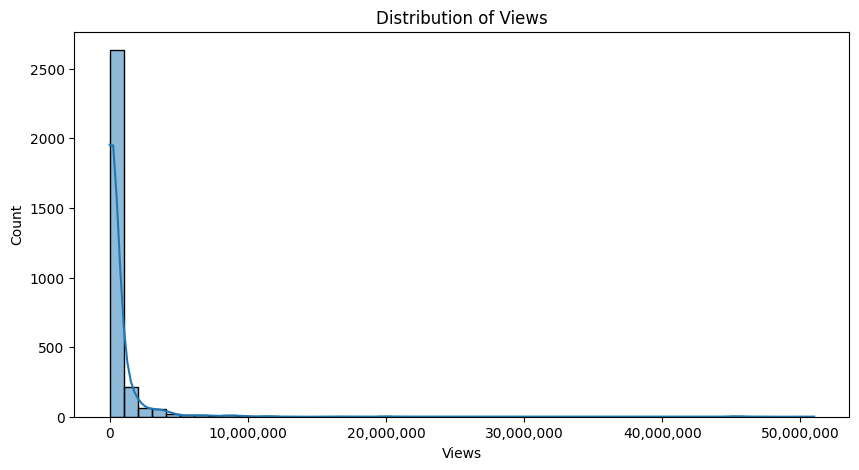

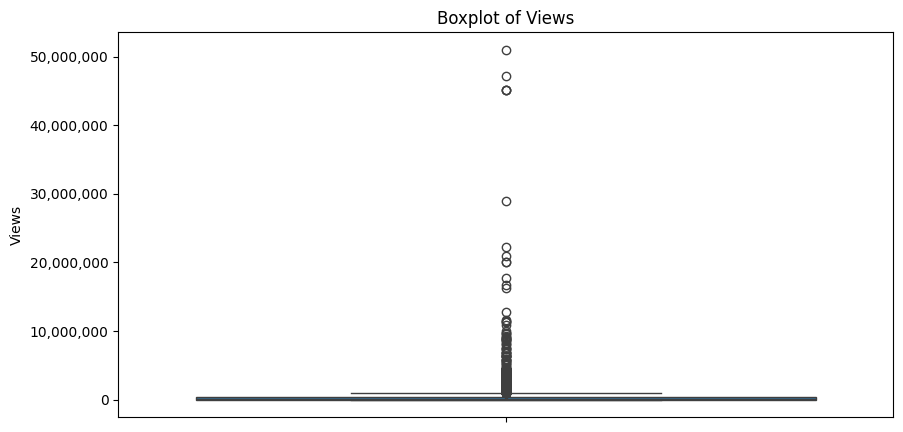

In [7]:
# Histogram for Views
plt.figure(figsize=(10, 5))
sns.histplot(df['views'], bins=50, kde=True)
plt.title('Distribution of Views')
plt.xlabel('Views')
plt.ylabel('Count')
plt.gca().xaxis.set_major_formatter(FuncFormatter(human_format))
plt.show()

# Boxplot for Views
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='views')
plt.title('Boxplot of Views')
plt.ylabel('Views')
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.show()

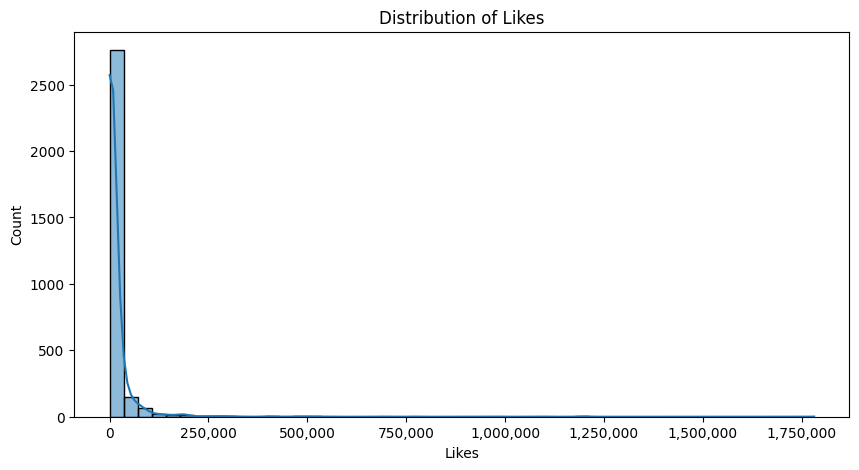

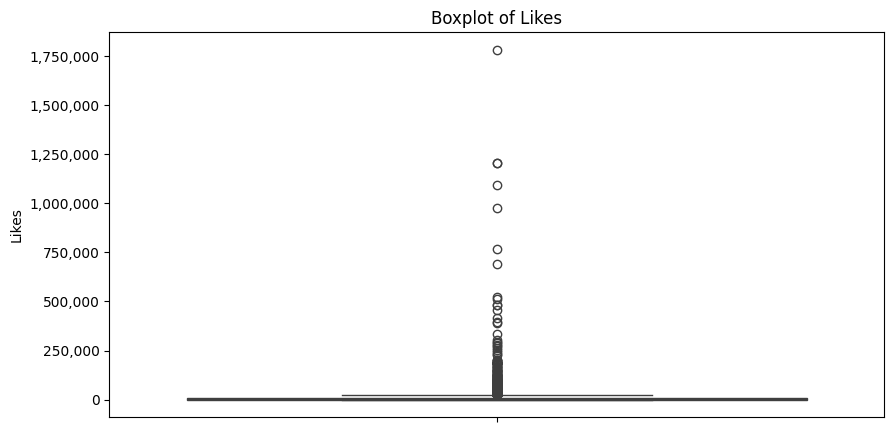

In [8]:
# Histogram for Likes
plt.figure(figsize=(10, 5))
sns.histplot(df['likes'], bins=50, kde=True)
plt.title('Distribution of Likes')
plt.xlabel('Likes')
plt.ylabel('Count')
plt.gca().xaxis.set_major_formatter(FuncFormatter(human_format))
plt.show()

# Boxplot for Likes
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='likes')
plt.title('Boxplot of Likes')
plt.ylabel('Likes')
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.show()

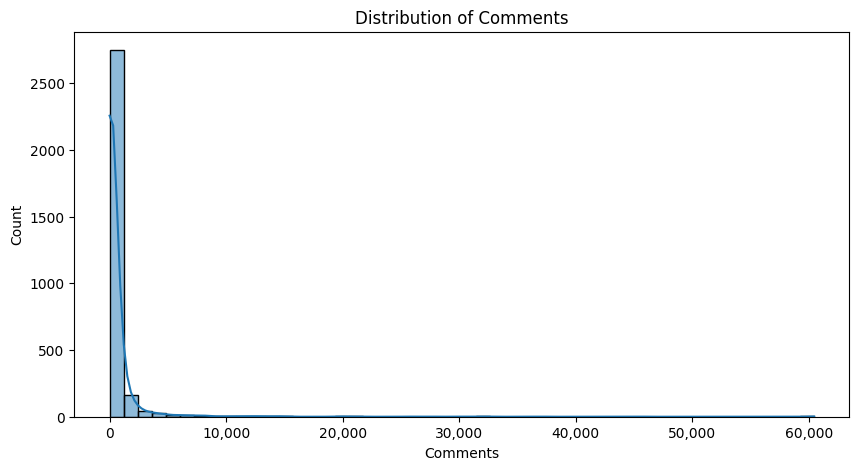

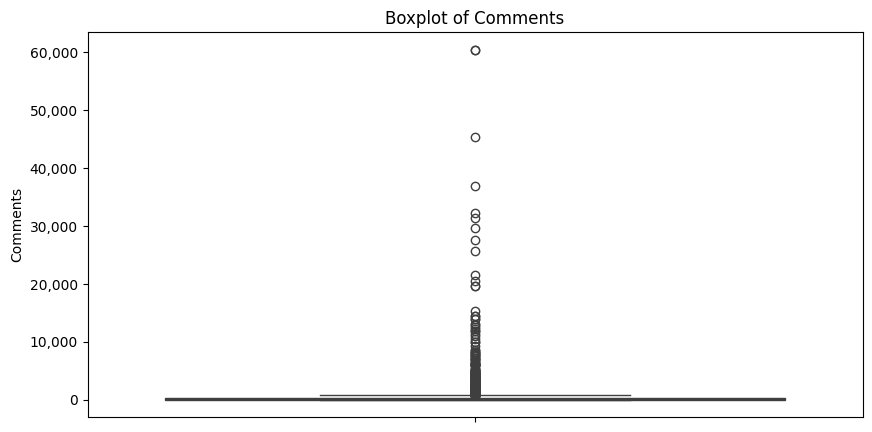

In [9]:
# Histogram for Comments
plt.figure(figsize=(10, 5))
sns.histplot(df['comments'], bins=50, kde=True)
plt.title('Distribution of Comments')
plt.xlabel('Comments')
plt.ylabel('Count')
plt.gca().xaxis.set_major_formatter(FuncFormatter(human_format))
plt.show()

# Boxplot for Comments
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='comments')
plt.title('Boxplot of Comments')
plt.ylabel('Comments')
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.show()

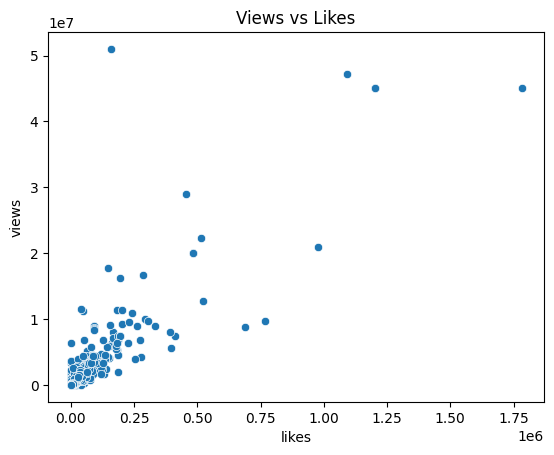

In [10]:
# Scatterplot
sns.scatterplot(data=df, x="likes", y="views")
plt.title("Views vs Likes")
plt.show()

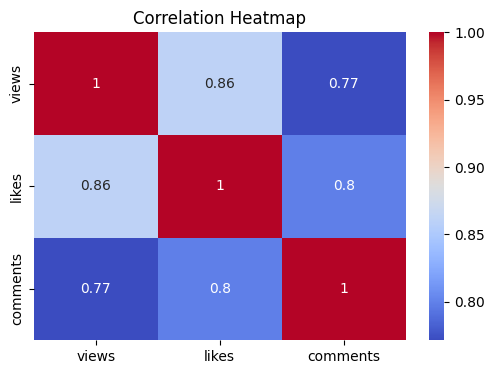

In [11]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[["views", "likes", "comments"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [12]:
# Convert publish time to datetime
df["published"] = pd.to_datetime(df["published"])

# Extract day of week and hour
df["publish_day"] = df["published"].dt.day_name()
df["publish_hour"] = df["published"].dt.hour

# Title features
df["title_length"] = df["title"].astype(str).apply(len)
df["word_count"] = df["title"].astype(str).apply(lambda x: len(x.split()))

# Engagement ratios
df["likes_per_view"] = df["likes"] / df["views"]
df["comments_per_view"] = df["comments"] / df["views"]

df[["title", "views", "likes", "comments", "title_length", "word_count", "likes_per_view", "comments_per_view"]].head()

,title,views,likes,comments,title_length,word_count,likes_per_view,comments_per_view
0,What is Data Science?,793311,16888,305,21,4,0,0
1,Intro to Data Science: What is Data Science?,124740,1788,43,44,8,0,0
2,The Complete Data Science Roadmap,445118,14356,360,33,5,0,0
3,Data Analytics vs Data Science,677108,13757,231,30,5,0,0
4,Data Science In 5 Minutes | Data Science For B...,4421608,62107,1101,92,17,0,0


In [13]:
# Remove videos with 0 views
df = df[df['views'] > 0]

# Remove extreme outliers in likes_per_view
df = df[df['likes_per_view'] < 1]  # likes can't exceed views

# Print how many videos remain
print(f"Videos remaining after filtering: {df.shape[0]}")

Videos remaining after filtering: 2994


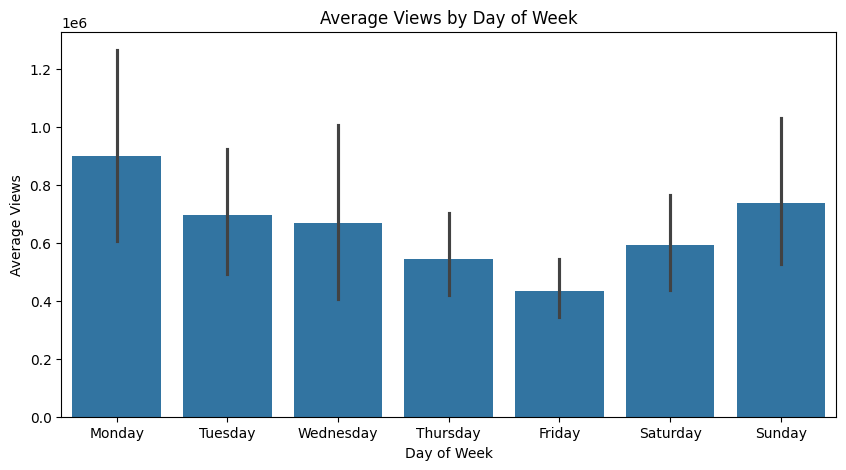

In [14]:
# Average views by publish day
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='publish_day', y='views', estimator='mean', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Average Views by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Views')
plt.show()

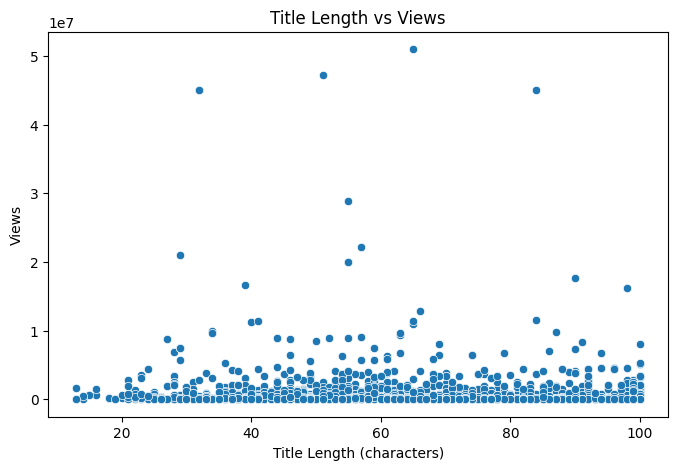

In [15]:
# Title length vs views
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='title_length', y='views')
plt.title('Title Length vs Views')
plt.xlabel('Title Length (characters)')
plt.ylabel('Views')
plt.show()

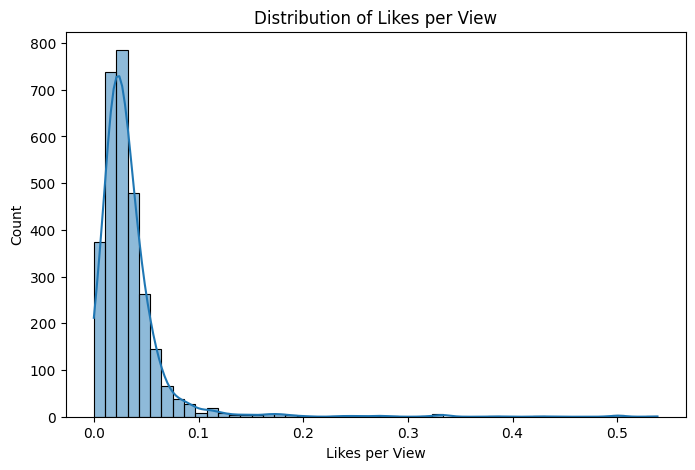

In [16]:
# Likes per view distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['likes_per_view'], bins=50, kde=True)
plt.title('Distribution of Likes per View')
plt.xlabel('Likes per View')
plt.ylabel('Count')
plt.show()